In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
from shapely.geometry import Polygon, MultiPolygon
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm, LogNorm
from cmcrameri import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle 
import matplotlib.ticker as mticker
import sklearn
import importlib
import cartopy.crs as ccrs

import sys
sys.path.append('../')
import snowFun

In [2]:
import importlib
importlib.reload(snowFun)

<module 'snowFun' from 'C:\\Users\\lzell\\OneDrive - Colostate\\Desktop\\AGVA\\scripts\\Figures\\..\\snowFun\\__init__.py'>

In [3]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")
folder_climate = os.path.join(folder_AGVA, "Climate")

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi, include_fields=['RGIId', 'geometry'])

# open the big data csv
path_data = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Final_Data_Table.csv')
data_df = pd.read_csv(path_data)

# subset rgi to the glaciers we have data for
rgi_gdf = rgi_gdf[ rgi_gdf['RGIId'].isin(data_df['RGIId']) ]
# print(rgi_gdf.columns)

# merge columns
all_data_gdf = gpd.GeoDataFrame(pd.merge(data_df, rgi_gdf, on="RGIId"))

# replace -9999 with nan
all_data_gdf[all_data_gdf==-9999] = np.nan

# what columns are available?
print(all_data_gdf.shape)
print(all_data_gdf.columns.values)

(3002, 80)
['RGIId' 'GLIMSId' 'BgnDate' 'EndDate' 'CenLon' 'CenLat' 'O1Region'
 'O2Region' 'Area' 'Zmin' 'Zmax' 'Zmed' 'Slope' 'Aspect' 'Lmax' 'Status'
 'Connect' 'Form' 'TermType' 'Surging' 'Linkages' 'Name' 'O3Region'
 'O3_name' 'ela_2018' 'ela_2019' 'ela_2020' 'ela_2021' 'ela_2022'
 'aar_2018' 'aar_2019' 'aar_2020' 'aar_2021' 'aar_2022' 'off_glacier_2018'
 'off_glacier_2019' 'off_glacier_2020' 'off_glacier_2021'
 'off_glacier_2022' 'date_2018' 'date_2019' 'date_2020' 'date_2021'
 'date_2022' 'ela_avg_product' 'aar_avg_product' 'aar_infill_avg_product'
 'off_glacier_avg_product' 'percent_observed_average_product' 'dhdt_1520'
 'dhdt_1020' 'distance_from_ocean' 'hyps_ela' 'hyps_aar' 'hyps_aar_20'
 'hyps_aar_40' 'hyps_aar_60' 'hyps_aar_80' 'hyps_aar_100' 'hyps_aar_120'
 'hyps_aar_140' 'hyps_aar_160' 'hyps_aar_180' 'hyps_aar_200'
 'hyps_aar_220' 'hyps_aar_240' 'hyps_aar_260' 'hyps_aar_280'
 'hyps_aar_300' 'hyps_aar_320' 'hyps_aar_340' 'hyps_aar_360'
 'hyps_aar_380' 'hyps_aar_400' 'hyps_a

In [4]:
# add columns for percent AA lost at 100, 200m
all_data_gdf['aa_lost_100'] = (all_data_gdf['hyps_aar']-all_data_gdf['hyps_aar_100'])*100/all_data_gdf['hyps_aar']
all_data_gdf['aa_lost_200'] = (all_data_gdf['hyps_aar']-all_data_gdf['hyps_aar_200'])*100/all_data_gdf['hyps_aar']

In [5]:
### get the hypsometric analysis stats
# find hypsometric aar
all_data_gdf["hyps_aar_0"] = all_data_gdf["hyps_aar"]
all_data_gdf['hyps_aa'] = all_data_gdf["hyps_aar"] * all_data_gdf["Area"]
all_data_gdf['hyps_0_aa'] = all_data_gdf["hyps_aar"] * all_data_gdf["Area"]
for i in np.arange(0,201,20):
    all_data_gdf[f'hyps_{i}_aa'] = all_data_gdf[f"hyps_aar_{i}"] * all_data_gdf["Area"]

In [6]:
# get hypsometric aa, aar for each 03region
o3_df = pd.DataFrame(all_data_gdf.groupby('O3Region')['Area'].sum().rename('area'))
o3_df['hyps_aa'] = all_data_gdf.groupby('O3Region')[f'hyps_aa'].sum()
o3_df['hyps_aar'] = o3_df[f'hyps_aa']/o3_df['area']
for i in np.arange(0,201,20):
    o3_df[f'hyps_{i}_aa'] = all_data_gdf.groupby('O3Region')[f'hyps_{i}_aa'].sum()
    o3_df[f'hyps_{i}_aar'] = o3_df[f'hyps_{i}_aa']/o3_df['area']

# remove the glaciers in O3Region=0 (these are glaciers that don't fit into any of the regions)
o3_df = o3_df.drop(0, axis=0).reset_index()
o3_df

,O3Region,area,hyps_aa,hyps_aar,hyps_0_aa,hyps_0_aar,hyps_20_aa,hyps_20_aar,hyps_40_aa,hyps_40_aar,...,hyps_120_aa,hyps_120_aar,hyps_140_aa,hyps_140_aar,hyps_160_aa,hyps_160_aar,hyps_180_aa,hyps_180_aar,hyps_200_aa,hyps_200_aar
0,1,1554.897,407.223767,0.261898,407.223767,0.261898,378.544048,0.243453,349.964939,0.225073,...,250.531549,0.161124,229.957283,0.147892,210.190259,0.135180,191.710929,0.123295,174.079741,0.111956
1,2,2359.375,777.350314,0.329473,777.350314,0.329473,721.858947,0.305953,667.537844,0.282930,...,469.498301,0.198993,427.723393,0.181287,388.574038,0.164694,349.785102,0.148253,314.781367,0.133417
2,3,1710.748,563.735018,0.329525,563.735018,0.329525,537.668989,0.314289,513.933733,0.300415,...,431.085586,0.251987,413.204136,0.241534,397.666197,0.232452,383.452032,0.224143,369.916852,0.216231
3,4,3275.767,1114.945882,0.340362,1114.945882,0.340362,1076.829458,0.328726,1040.092819,0.317511,...,898.170404,0.274186,865.594440,0.264242,834.133438,0.254638,805.602428,0.245928,778.094913,0.237531
4,5,2323.194,794.951379,0.342180,794.951379,0.342180,752.126980,0.323747,709.726085,0.305496,...,556.645433,0.239604,521.485986,0.224469,488.360995,0.210211,456.277103,0.196401,424.932308,0.182909
5,6,4323.462,2191.497681,0.506885,2191.497681,0.506885,2132.342514,0.493203,2070.919429,0.478996,...,1828.524103,0.422931,1767.582875,0.408835,1705.998400,0.394591,1648.512437,0.381295,1592.020073,0.368228
6,7,263.569,108.566805,0.411910,108.566805,0.411910,99.000442,0.375615,89.306701,0.338836,...,55.123793,0.209144,47.786738,0.181306,41.540742,0.157609,35.703525,0.135462,30.015368,0.113880
7,8,2139.982,1020.242331,0.476753,1020.242331,0.476753,966.102649,0.451454,906.049719,0.423391,...,688.442891,0.321705,632.110982,0.295381,580.563608,0.271294,536.618615,0.250758,492.597909,0.230188
8,9,1595.633,755.152330,0.473262,755.152330,0.473262,712.940335,0.446807,671.293063,0.420706,...,506.100343,0.317178,467.762768,0.293152,429.041180,0.268885,394.402798,0.247176,359.922293,0.225567
9,10,6750.535,2752.174907,0.407697,2752.174907,0.407697,2639.251896,0.390969,2530.311513,0.374831,...,2134.681880,0.316224,2046.450218,0.303154,1961.208437,0.290526,1880.302743,0.278541,1805.271020,0.267426


In [7]:
# get hypsometric aa, aar for each 02region
o2_df = pd.DataFrame(all_data_gdf.groupby('O2Region')['Area'].sum().rename('area'))
o2_df['hyps_aa'] = all_data_gdf.groupby('O2Region')[f'hyps_aa'].sum()
o2_df['hyps_aar'] = o2_df[f'hyps_aa']/o2_df['area']
for i in np.arange(0,201,20):
    o2_df[f'hyps_{i}_aa'] = all_data_gdf.groupby('O2Region')[f'hyps_{i}_aa'].sum()
    o2_df[f'hyps_{i}_aar'] = o2_df[f'hyps_{i}_aa']/o2_df['area']
o2_df

,area,hyps_aa,hyps_aar,hyps_0_aa,hyps_0_aar,hyps_20_aa,hyps_20_aar,hyps_40_aa,hyps_40_aar,hyps_60_aa,...,hyps_120_aa,hyps_120_aar,hyps_140_aa,hyps_140_aar,hyps_160_aa,hyps_160_aar,hyps_180_aa,hyps_180_aar,hyps_200_aa,hyps_200_aar
O2Region,,,,,,,,,,,,,,,,,,,,,
2,14001.540,5442.583584,0.388713,5442.583584,0.388713,5220.879473,0.372879,5002.244078,0.357264,4790.075270,...,4183.927854,0.298819,3995.591082,0.285368,3814.733068,0.272451,3643.629103,0.260231,3479.745513,0.248526
3,1554.897,407.223767,0.261898,407.223767,0.261898,378.544048,0.243453,349.964939,0.225073,320.436394,...,250.531549,0.161124,229.957283,0.147892,210.190259,0.135180,191.710929,0.123295,174.079741,0.111956
4,10749.719,4636.136374,0.431280,4636.136374,0.431280,4417.295321,0.410922,4196.960996,0.390425,3985.159129,...,3384.348908,0.314831,3194.110707,0.297134,3012.353967,0.280226,2847.027681,0.264847,2687.806589,0.250035
5,31321.245,14936.491844,0.476881,14936.491844,0.476881,14605.181431,0.466303,14253.112709,0.455062,13906.359492,...,12873.659512,0.411020,12550.537954,0.400704,12213.655625,0.389948,11865.789848,0.378842,11528.676328,0.368078
6,18663.934,8147.524245,0.436538,8147.524245,0.436538,7771.315925,0.416381,7393.551610,0.396141,7015.905294,...,5901.086356,0.316176,5555.256895,0.297647,5218.194171,0.279587,4899.304578,0.262501,4598.805365,0.246401


In [8]:
# define a 16-color categorical color palette
# http://vrl.cs.brown.edu/color
from matplotlib.colors import ListedColormap
# hex_codes = ["#a0e3b7", "#b33c85", "#37b51f", "#b32df9", "#7e9b3d", "#333dcd", "#c0e15c", "#fe7dda", "#235e31", "#be0332", "#20d8fd", "#6c3640", "#21f0b6", "#ec7f6a", "#0362a0", "#f79302"]
# hex_codes = ["#3c2d80", "#609111", "#e30293", "#20502e", "#ec102f", "#219571", "#ce5d8e", "#3d8bb7", "#b94403", "#a143f9", "#604020", "#577cf5", "#ae783e", "#4b03a9", "#9679a6", "#154975"]
hex_codes = ["#097969","#FF3131","#CC5500","#D2042D","#880808","#EC5800","#1434A4","#3d8bb7","#0000FF","#577cf5","#FFD700","#C4B454","#DA70D6","#702963","#9679a6","#9F2B68"]
cmap_16 = ListedColormap(hex_codes)

# create list of o3region numbers, names, hex codes
numbers = np.arange(1,17)
names = [ all_data_gdf[all_data_gdf['O3Region']==n]['O3_name'].values[0] for n in numbers]
colors = [ hex_codes[n-1] for n in numbers ]
names[11] = 'St Elias Mountains'

o3_info_df = pd.DataFrame({'Number':numbers, 'Name':names, 'Color':colors})
o3_info_df

,Number,Name,Color
0,1,Aleutian Range,#097969
1,2,Northern Aleutian Range,#FF3131
2,3,Western Alaska Range,#CC5500
3,4,Central Alaska Range,#D2042D
4,5,Eastern Alaska Range,#880808
5,6,Wrangell Mountains,#EC5800
6,7,Talkeetna Mountains,#1434A4
7,8,Southern Kenai Mountains,#3d8bb7
8,9,Northern Kenai Mountains,#0000FF
9,10,Western Chugach Mountains,#577cf5


In [9]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

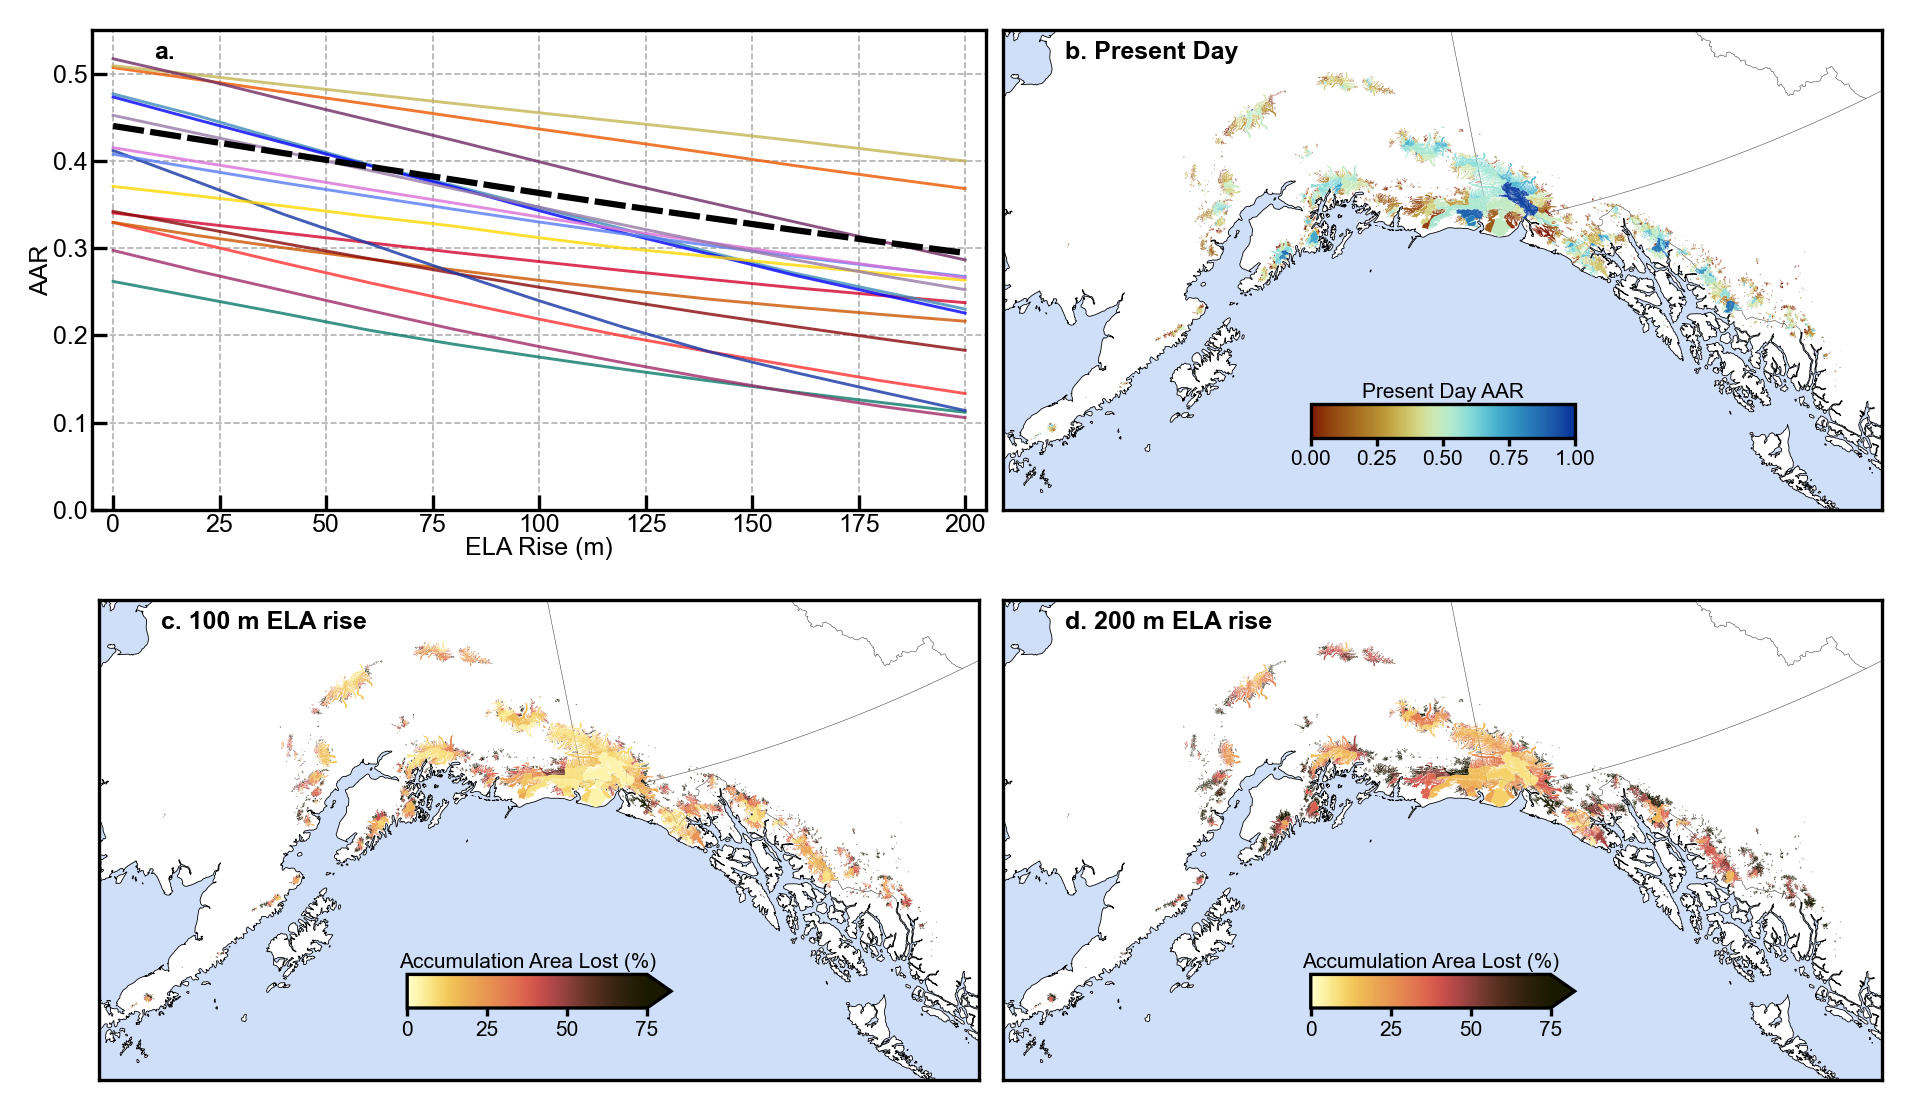

In [10]:
# start figure
fig,axs = snowFun.create_three_base_maps(hillshade=0)
ax0, ax1, ax2, axp = (axs[0,1], axs[1,0], axs[1,1], axs[0,0])

# cmap_pad = -0.2
# cmap_fraction = 0.03

# create inset cbar axes
cloc = (0.35,0.15,0.3,0.07)
cb_ax0 = ax0.inset_axes( cloc, transform=ax0.transAxes)
cb_ax1 = ax1.inset_axes( cloc, transform=ax1.transAxes)
cb_ax2 = ax2.inset_axes( cloc, transform=ax2.transAxes)

# add data to maps
im = all_data_gdf.plot(ax=ax0, column='hyps_aar', zorder=10, cmap=cm.roma, legend=True, vmin=0, vmax=1,
                          legend_kwds={'cax':cb_ax0, 'ticks':[0,0.25,0.5,0.75,1], 'orientation':'horizontal'})

im = all_data_gdf.plot(ax=ax1, column='aa_lost_100', zorder=10, cmap=cm.lajolla_r, legend=True, vmin=0, vmax=75,
                          legend_kwds={'cax':cb_ax1, 'ticks':[0,25,50,75], 'orientation':'horizontal',
                                       'extend':'max', "extendfrac":0.1})

im = all_data_gdf.plot(ax=ax2, column='aa_lost_200', zorder=10, cmap=cm.lajolla_r, legend=True, vmin=0, vmax=75,
                          legend_kwds={'cax':cb_ax2, 'ticks':[0,25,50,75], 'orientation':'horizontal',
                                       'extend':'max', "extendfrac":0.1})

# format colorbars
labels = ['Present Day AAR', 'Accumulation Area Lost (%)', 'Accumulation Area Lost (%)']
for i,ax in enumerate([cb_ax0,cb_ax1,cb_ax2]):
    ax.tick_params(labelsize=5, length=2, pad=1)
    ax.set_xlabel(labels[i], size=5, labelpad=1.5) 
    ax.xaxis.set_label_position('top')

# format titles on each plot
labels = ['a.', 'b. Present Day','c. 100 m ELA rise','d. 200 m ELA rise']
for i,ax in enumerate([axp, ax0, ax1, ax2]):
    ax.set_title("")
    ax.text(0.07, 0.94, labels[i],
            fontsize=6, weight='bold',
            transform = ax.transAxes)
    
### plot timeseries in other axis
cmap = mpl.colormaps['prism']
cmap = ListedColormap(cmap(np.linspace(0, 1, 17)))
cmap = cmap_16

# make separate line for each subregion
for idx,row in o3_df.iterrows():
    xs = np.arange(0,201,20)
    ys = [row[f'hyps_{x}_aar'] for x in xs]
    axp.plot(xs,ys, c=cmap(idx), linestyle='solid', alpha=0.8, linewidth=0.7)

# lastly, plot the entire region's AAR change
ys = []
for x in xs:
    ys.append( np.nansum(all_data_gdf[f"hyps_{x}_aa"])/np.nansum(all_data_gdf["Area"]) )
axp.plot(xs, ys, c='black', linewidth=1.5, linestyle=(0, (5,1)))

axp.set_xlim(-5,205)
axp.set_ylim(0,0.55)
axp.set_xlabel("ELA Rise (m)", size=6, labelpad=0)
axp.set_ylabel("AAR", size=6, labelpad=0)
axp.tick_params(axis='both', direction='in', labelsize=6, pad=1)
axp.grid(zorder=1, linestyle='dashed', linewidth=0.4)

# final touches
plt.tight_layout()
plt.subplots_adjust(wspace=0.01)

# save
out_path = os.path.join(folder_AGVA, 'Figures', 'future aars', 'future_aars2.png')
# plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)

In [11]:
print(xs)
print(ys)

[  0  20  40  60  80 100 120 140 160 180 200]
[0.4400232321730902, 0.42459889052668964, 0.4089040299714247, 0.39346454716384244, 0.37838965572564703, 0.36323088330542397, 0.3485789595738494, 0.3345786768602228, 0.320732716100721, 0.30734109107279356, 0.29451724153732534]


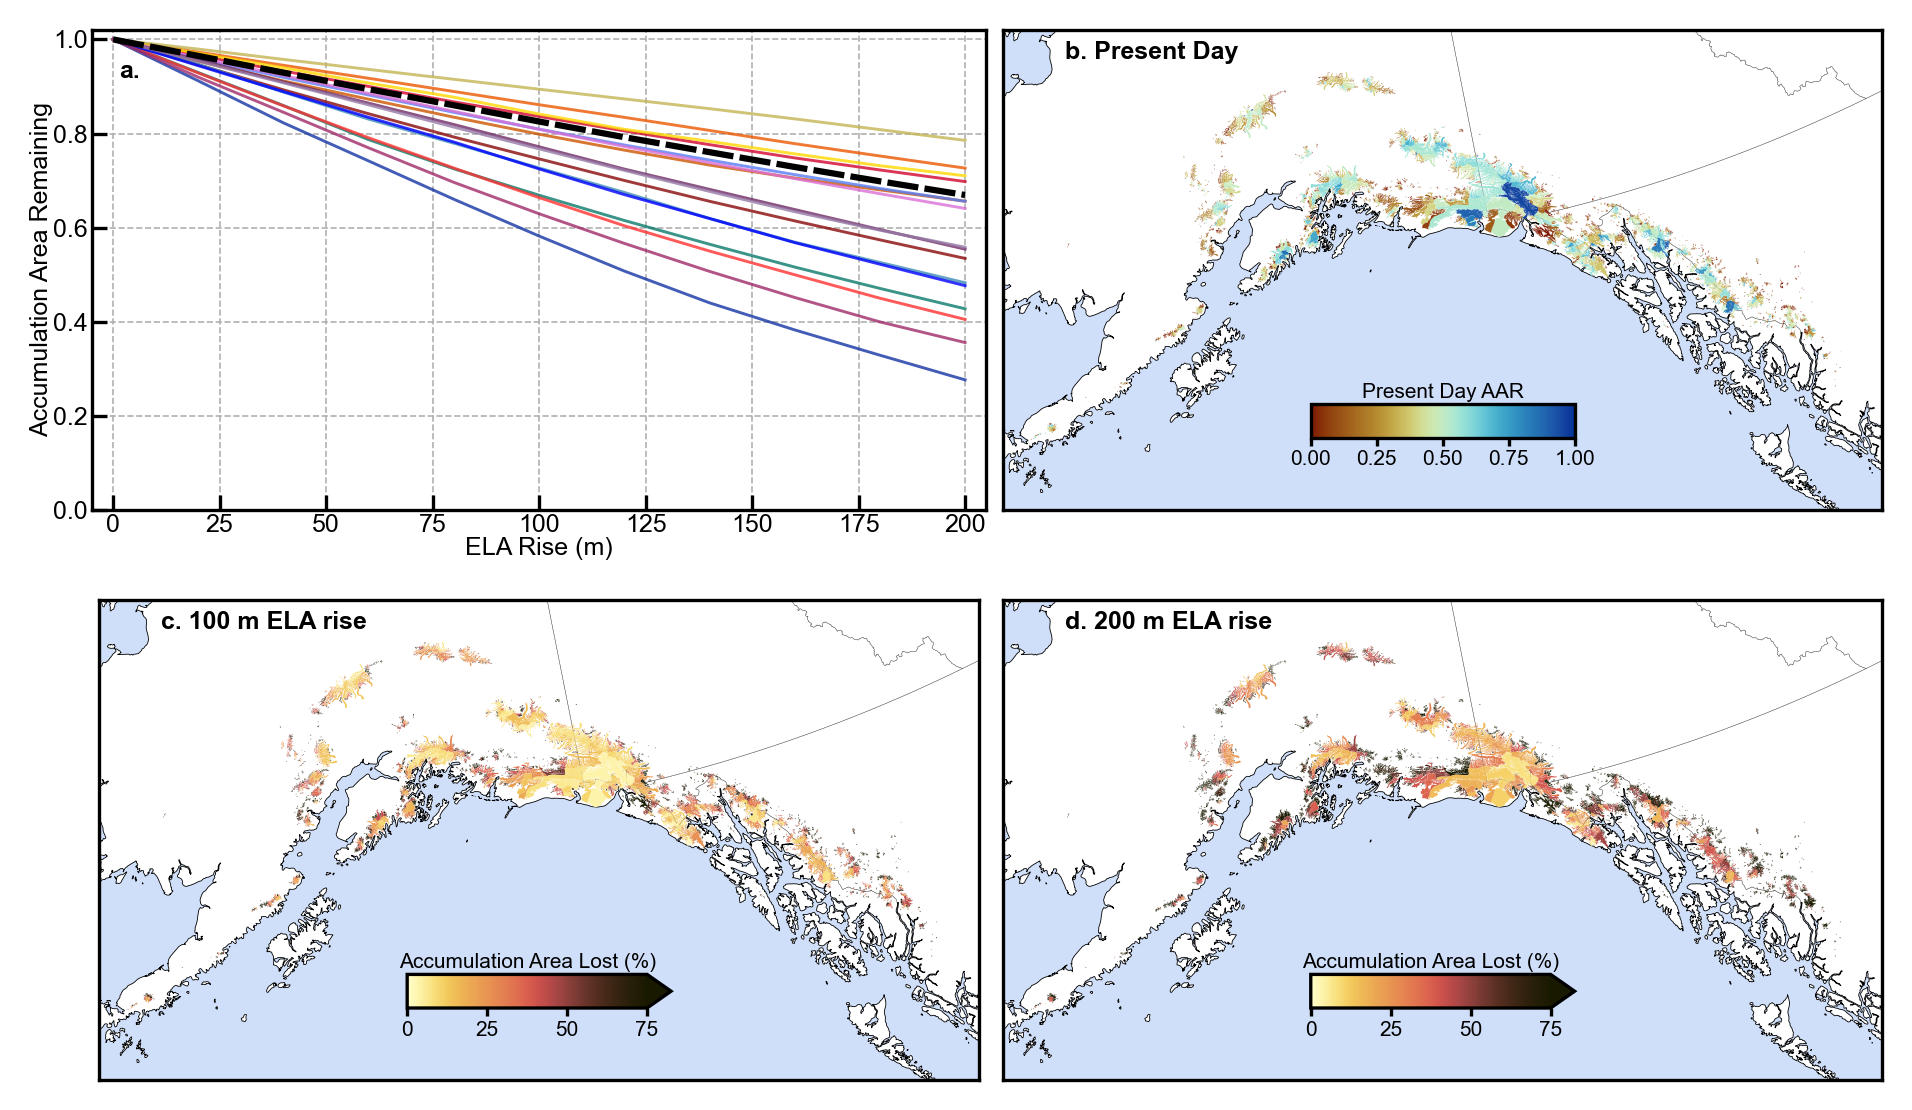

In [18]:
# start figure
fig,axs = snowFun.create_three_base_maps(hillshade=0)
ax0, ax1, ax2, axp = (axs[0,1], axs[1,0], axs[1,1], axs[0,0])

# cmap_pad = -0.2
# cmap_fraction = 0.03

# create inset cbar axes
cloc = (0.35,0.15,0.3,0.07)
cb_ax0 = ax0.inset_axes( cloc, transform=ax0.transAxes)
cb_ax1 = ax1.inset_axes( cloc, transform=ax1.transAxes)
cb_ax2 = ax2.inset_axes( cloc, transform=ax2.transAxes)

# add data to maps
im = all_data_gdf.plot(ax=ax0, column='hyps_aar', zorder=10, cmap=cm.roma, legend=True, vmin=0, vmax=1,
                          legend_kwds={'cax':cb_ax0, 'ticks':[0,0.25,0.5,0.75,1], 'orientation':'horizontal'})

im = all_data_gdf.plot(ax=ax1, column='aa_lost_100', zorder=10, cmap=cm.lajolla_r, legend=True, vmin=0, vmax=75,
                          legend_kwds={'cax':cb_ax1, 'ticks':[0,25,50,75], 'orientation':'horizontal',
                                       'extend':'max', "extendfrac":0.1})

im = all_data_gdf.plot(ax=ax2, column='aa_lost_200', zorder=10, cmap=cm.lajolla_r, legend=True, vmin=0, vmax=75,
                          legend_kwds={'cax':cb_ax2, 'ticks':[0,25,50,75], 'orientation':'horizontal',
                                       'extend':'max', "extendfrac":0.1})

# format colorbars
labels = ['Present Day AAR', 'Accumulation Area Lost (%)', 'Accumulation Area Lost (%)']
for i,ax in enumerate([cb_ax0,cb_ax1,cb_ax2]):
    ax.tick_params(labelsize=5, length=2, pad=1)
    ax.set_xlabel(labels[i], size=5, labelpad=1.5) 
    ax.xaxis.set_label_position('top')

# format titles on each plot
labels = ['b. Present Day','c. 100 m ELA rise','d. 200 m ELA rise']
for i,ax in enumerate([ax0, ax1, ax2]):
    ax.set_title("")
    ax.text(0.07, 0.94, labels[i],
            fontsize=6, weight='bold',
            transform = ax.transAxes)
    
axp.set_title("")
axp.text(0.03, 0.90, 'a.',
            fontsize=6, weight='bold',
            transform = axp.transAxes)
    
### plot timeseries in other axis
cmap = mpl.colormaps['prism']
cmap = ListedColormap(cmap(np.linspace(0, 1, 17)))
cmap = cmap_16

# make separate line for each subregion
for idx,row in o3_df.iterrows():
    xs = np.arange(0,201,20)
    ys = [row[f'hyps_{x}_aar']/row[f'hyps_0_aar'] for x in xs]
    axp.plot(xs,ys, c=cmap(idx), linestyle='solid', alpha=0.8, linewidth=0.7)

# lastly, plot the entire region's AAR change
aar_today = np.nansum( (all_data_gdf[f"hyps_0_aa"]) / np.nansum(all_data_gdf["Area"]) )
ys = []
for x in xs:
    aar_future = np.nansum( (all_data_gdf[f"hyps_{x}_aa"]) / np.nansum(all_data_gdf["Area"]) )
    ys.append(aar_future/aar_today)
    
axp.plot(xs, ys, c='black', linewidth=1.5, linestyle=(0, (5,1)))

axp.set_xlim(-5,205)
axp.set_ylim(0,1.02)
axp.set_xlabel("ELA Rise (m)", size=6, labelpad=0)
axp.set_ylabel("Accumulation Area Remaining", size=6, labelpad=0)
axp.tick_params(axis='both', direction='in', labelsize=6, pad=1)
axp.grid(zorder=1, linestyle='dashed', linewidth=0.4)

# final touches
plt.tight_layout()
plt.subplots_adjust(wspace=0.01)

# save
out_path = os.path.join(folder_AGVA, 'Figures', 'future aars', 'future_aars1.png')
plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)

In [13]:
xs

array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200])

In [14]:
ys

[1.0,
 0.9649465289134252,
 0.929278274585683,
 0.8941903935860069,
 0.8599310855859569,
 0.8254811490556507,
 0.7921830805440977,
 0.7603659361526867,
 0.7288995049574012,
 0.6984656004524235,
 0.6693220266639743]

In [15]:
(o3_df['hyps_200_aar']/o3_df['hyps_0_aar']).sort_values()

6     0.276469
15    0.355732
1     0.404941
0     0.427479
8     0.476622
7     0.482824
4     0.534539
13    0.554218
14    0.558328
12    0.640769
9     0.655943
2     0.656189
3     0.697877
10    0.710190
5     0.726453
11    0.785435
dtype: float64

In [16]:
np.nansum(all_data_gdf[f"hyps_200_aa"])

22469.1135374

In [17]:
np.nansum(all_data_gdf[f"Area"])

76291.33499999999